# M6A Analysis Part 2

In this part we will parse the m6A peak files to compute the m6A peak intensity,
and use the m6A intensities to compute and visualize differential methylated sites.

Pre-requisites:
- Finish running CLAM Snakemake pipeline
- Pre-parsed peak intensities [optional; saves huge time]

In [1]:
# Global variables
PRECOMPUTE = TRUE
SAVE_FIG = TRUE

## Compute m6A peak intensity

### Parse the BAM files

In [2]:
# Use this python script for computing m6A peak intensity
# This takes a long time as it parses all BAM files to 
# count the RPKM for peak windows.
# Alternatively, use the pre-computed files:
# ['input_peak.RPKM.csv', 'IP_peak.RPKM.csv', 'peak_intensity.csv', 'differential_sites_log1.5.csv']
if(! PRECOMPUTE) {
    system("python scripts/parse_peaks.py")
    }
data = read.table('../_data/m6A/peak_intensity_cluster/peak_intensity.csv')
rownames(data) = sapply(strsplit(rownames(data), ":"), function(x) paste0(x[1], ":", paste0(c(x[2],x[3]),collapse="-")))

In [3]:
# a snippet of the data
data[1:3,1:4]
# summary statistics
cat("dim(data)=",dim(data),"\n")
cat("min(data)=",min(data),"\n")
cat("max(data)=",max(data),"\n")

,F_KI_06,F_KI_07,F_KI_08,F_KI_09
chr12:109612940-109613040,1.000000,1.000000,0.2224945,2.497089
chr12:4880532-4880632,3.167406,3.227586,4.9811622,4.567099
chr14:75906737-75906837,2.450675,4.200557,4.5289980,2.684488


dim(data)= 59493 54 
min(data)= 0.01340384 
max(data)= 394.8107 


In [4]:
#write.table(data, file="peak_intensity.tsv", quote=F, sep='\t')

### Unsupervised m6A intensity clustering

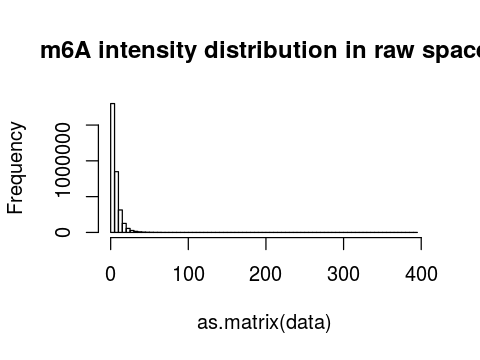

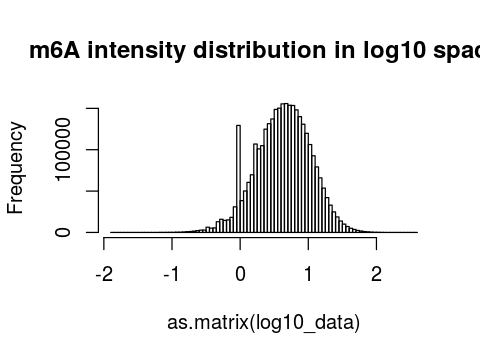

In [5]:
source('scripts/Heatmap.3.R')
library(repr)

log10_data = log10(data)

options(repr.plot.width=4, repr.plot.height=3)
hist(as.matrix(data), breaks=100, main='m6A intensity distribution in raw space')
hist(as.matrix(log10_data), breaks=100, main='m6A intensity distribution in log10 space')

png 
  2

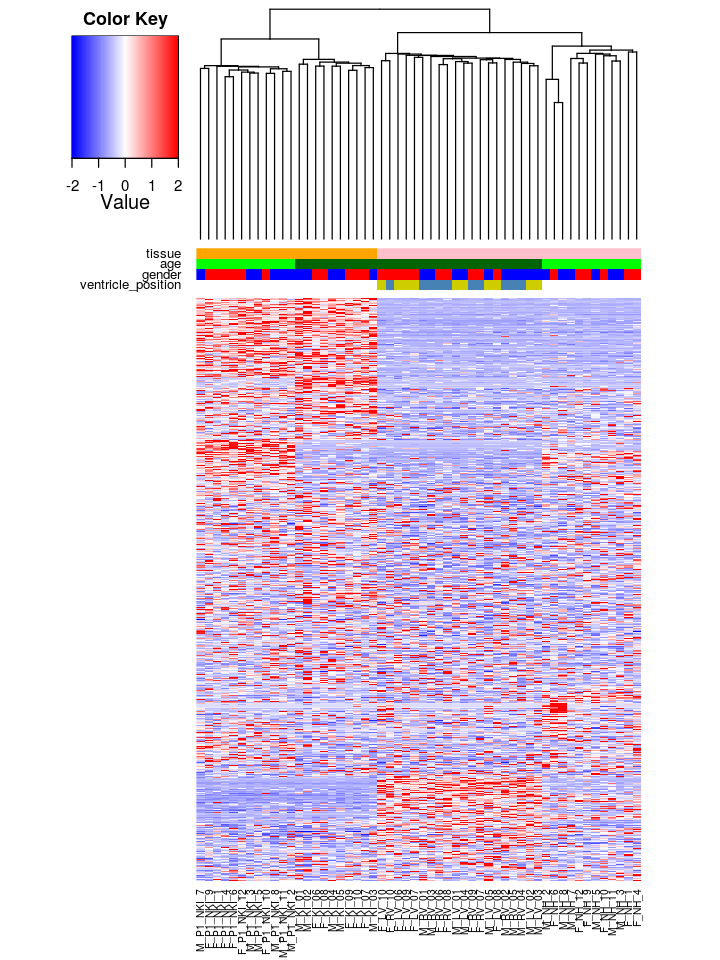

In [6]:
rowVar = apply(log10_data, 1, function(x) var(x)/mean(x))

y = as.matrix(data[order(-rowVar)[1:5000],])
y = t(scale(t(y)))
               
# use 1-correlation as distance metric
hr = hclust(as.dist(1-cor(t(y), method="spearman")), method="average")
#hr = hclust(dist(y), method="average")
hc = hclust(as.dist(1-cor(y, method="pearson")), method="average")
#hc = hclust(dist(t(y)), method="average")


palette <- colorRampPalette(c("blue","white","red"))

clab = data.frame(
    ventricle_position = 'white',
    gender = 'white',
    age = sapply(colnames(y), function(x) ifelse(length(grep('N',x)), 'green', 'darkgreen')),
    tissue = sapply(colnames(y), function(x) ifelse(length(grep('KI',x)), 'orange', 'pink')),
    stringsAsFactors=F
)
clab$gender[ grep('M', colnames(y)) ] = 'blue'
clab$gender[ grep('F', colnames(y)) ] = 'red'
clab$ventricle_position[ grep('RV', colnames(y)) ] = 'steelblue'
clab$ventricle_position[ grep('LV', colnames(y)) ] = 'yellow3'


clab = as.matrix(clab)

breaks = c(seq(-2, 0,length=100),seq(0, 2,length=100))


options(repr.plot.width=6, repr.plot.height=8)
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "col", col = palette, 
        labRow=F, breaks=breaks,
        ColSideColors = clab, key = TRUE)

if(SAVE_FIG) {
    pdf('_data/PeakIntensity_top5000CoV.pdf')
    heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "col", col = palette, 
              labRow=F, breaks=breaks,
              ColSideColors = clab, key = TRUE)
    dev.off()
}

### Differential m6A sites detection

>Old: This is parsed within the `parse_peaks.py`. 

Updated 2.9.2019: Now the differential peak calling has been moved to an independent script `diff_peaks.py`. The differential calculation in the `parse_peaks.py` has been removed.

Differential m6A criteria:
- At least 1.5 fold change of peak intensities of the average intensity across samples; 
- Average Input window RPKM >= 5 across samples;
- Average Input gene TPM >= 1 in at least one condition (considering tissue/stage-specific);
- At least 50% samples/replicates in higher peak intensity group must be called as having peak;
- Wilcoxon & t-test between two groups intensities must be significant (<0.05).

Additionally:
- Differential peaks on DEseq2 signficantly differential genes (padj<0.05, log2Foldchange>1) are noted as `is_tissue_specific`

## Supervised m6A peaks intensity clustering

Read the list of differential peaks generated by `diff_peak.py`, then plot the heatmaps. 

First read in the data and plot the summary statistics.

In [7]:
data = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5.csv', header=T, sep='\t')
data2 = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5-tissue_specific.csv', header=T, sep='\t')
if("X"%in%colnames(data))
{
    rownames(data) = data$X
    data = data[,-1]
}
if("url"%in%colnames(data))
{
    data = data[,c(1,2,3,4)]
}
if("X"%in%colnames(data2))
{
    rownames(data2) = data2$X
    data2 = data2[,-1]
}
if("url"%in%colnames(data2))
{
    data2 = data2[,c(1,2,3,4)]
}

#print(head(data))
#count = apply(data[,2:7], 2, function(x) length( which( (x>1.5|x<1/1.5) & x!=0 ) ))
count = apply(data, 2, function(x) length( which( (x>0 | x<0 ) )) )
count2 = apply(data2, 2, function(x) length( which( (x>0 | x<0 ) )) )
              
table_count = data.frame(
    compr = colnames(data),
    differential_count = count,
    stage_specific_count = count2
    )
print(table_count)

                compr differential_count stage_specific_count
Heart_Age   Heart_Age                906                  204
Kidney_Age Kidney_Age               1053                  366
AHK               AHK               1200                  537
NHK               NHK                511                  255


Using compr as id variables


       compr             variable value
1  Heart_Age   differential_count   906
2 Kidney_Age   differential_count  1053
3        AHK   differential_count  1200
4        NHK   differential_count   511
5  Heart_Age stage_specific_count   204
6 Kidney_Age stage_specific_count   366
7        AHK stage_specific_count   537
8        NHK stage_specific_count   255


Saving 6.67 x 6.67 in image


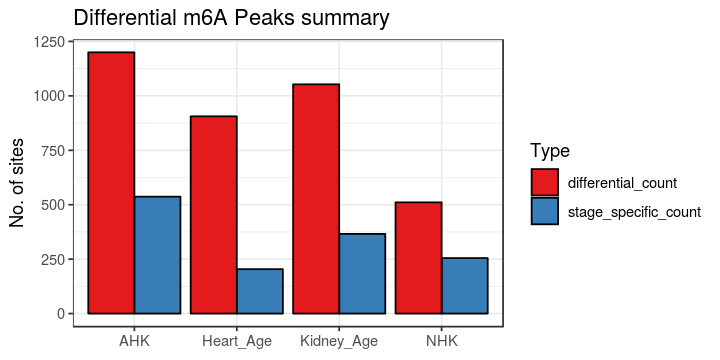

In [8]:
options(repr.plot.width=6, repr.plot.height=3)
library(ggplot2)
library(reshape2)
df_count = melt(table_count, ID='compr')
print(df_count)
p_bar = ggplot(data = df_count, aes(x = compr, y = value, fill = factor(variable))) +  
    geom_bar(stat="identity", width=0.9, colour="black", position="dodge") + 
    scale_fill_brewer(palette = 'Set1') +
    labs(title = "Differential m6A Peaks summary", y = "No. of sites", x = NULL, fill = "Type") +
    theme_bw()

print(p_bar)
if(SAVE_FIG) {
    ggsave('_data/DiffPeak_summary.pdf', plot=p_bar, useDingbats=F)
}

**Plot the sample clustering based on the differential m6A sites.**


Legend:
Column Colour Code:
-    Tissue: orange=Kidney, pink=Heart
-    Age: light green=Neonatal, dark green=Adult
-    Gender: blue=Male, red=Female

Row Colour Code:
-    Blue: neonatal_KI_V: neonatal kidney vs. neonatal heart
-    Orange: KI_age: neonatal kidney vs. adult kidney
-    Red: adult_KI_V: adult kidney vs. adult heart
-    Green: V_age: neonatal heart vs adult heart

[1] 3670   54


png 
  2

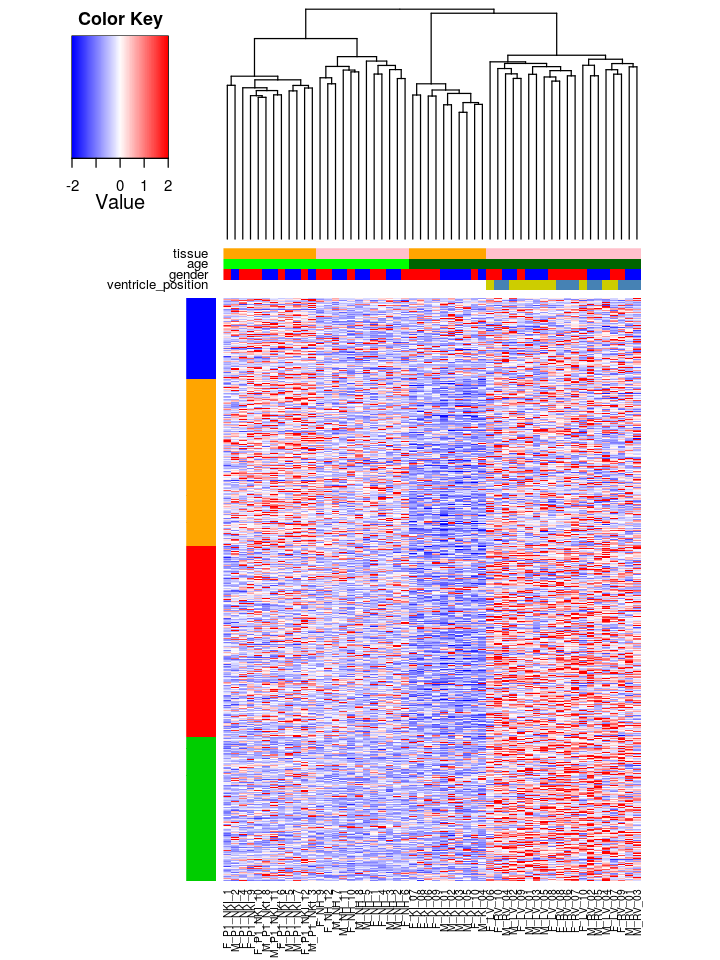

In [9]:
source('scripts/Heatmap.3.R')
data = read.table('../_data/m6A/peak_intensity_cluster/peak_intensity.csv') ## this file has updated gender
differential_sites = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5.csv', header=T, sep='\t')
if("X"%in%colnames(differential_sites))
{
    rownames(differential_sites) = differential_sites$X
    differential_sites = differential_sites[,-1]
}
if("url"%in%colnames(differential_sites))
{
    differential_sites = differential_sites[,c(1,2,3,4)]
    rownames(differential_sites) = gsub("-", ":", rownames(differential_sites))
}

diff_group = c()
diff_idx = c()
diff_peak = c()
comparison_color_code = c('blue', 'orange', 'red', 'green3')
#differential_sites = differential_sites[, c("neonatal_KI_V", "KI_age", "adult_KI_V", "V_age")]
differential_sites = differential_sites[, c("NHK", "Kidney_Age", "AHK", "Heart_Age")]
for(j in 1:ncol(differential_sites))
{
	comparison = colnames(differential_sites)[j]
	this_peak = rownames(differential_sites)[differential_sites[,j]!=0]
	diff_group = c(diff_group, rep( comparison_color_code[j], length(this_peak)))
	diff_peak = c(diff_peak, this_peak)
	diff_idx = c(diff_idx, match(this_peak, rownames(data)))

}

diff_df = data.frame(
	group=diff_group,
	peaks=diff_peak,
	idx=diff_idx,
	stringsAsFactors=F)

y = as.matrix(data[diff_df$idx,])
y = t(scale(t(y)))

#hr = hclust(as.dist(1-cor(t(y), method="spearman")), method="average")
#hc = hclust(as.dist(1-cor(y, method="pearson")), method="average")
hc = hclust(as.dist(1-cor(y, method="spearman")), method="complete")


palette <- colorRampPalette(c("blue","white","red"))

clab = data.frame(
	ventricle_position = 'white',
	gender = 'white',
	age = sapply(colnames(y), function(x) ifelse(length(grep('N',x)), 'green', 'darkgreen')),
	tissue = sapply(colnames(y), function(x) ifelse(length(grep('KI',x)), 'orange', 'pink')),

	stringsAsFactors=F
)
clab$gender[ grep('M', colnames(y)) ] = 'blue'
clab$gender[ grep('F', colnames(y)) ] = 'red'
clab$ventricle_position[ grep('RV', colnames(y)) ] = 'steelblue'
clab$ventricle_position[ grep('LV', colnames(y)) ] = 'yellow3'


clab = as.matrix(clab)
rlab = as.matrix(diff_group, nrow=1)

breaks = c(seq(-2, 0,length=100),seq(0, 2,length=100))

options(repr.plot.width=6, repr.plot.height=8)
print(dim(y))
heatmap.3(y, Rowv = NULL, Colv = as.dendrogram(hc), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab, key = TRUE,
    RowSideColors = t(rlab))

if(SAVE_FIG) {
pdf('_data/PeakIntensity_AllDifferential.pdf')
heatmap.3(y, Rowv = NULL, Colv = as.dendrogram(hc), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab, key = TRUE,
    RowSideColors = t(rlab))
dev.off()
}


**Plot the sample clustering based on the differential m6A sites with tissue/stage-specific gene expression.**


Legend:
Column Colour Code:
-    Tissue: orange=Kidney, pink=Heart
-    Age: light green=Neonatal, dark green=Adult
-    Gender: blue=Male, red=Female

Row Colour Code:
-    Blue: neonatal_KI_V: neonatal kidney vs. neonatal heart
-    Orange: KI_age: neonatal kidney vs. adult kidney
-    Red: adult_KI_V: adult kidney vs. adult heart
-    Green: V_age: neonatal heart vs adult heart

[1] 1362   54


png 
  2

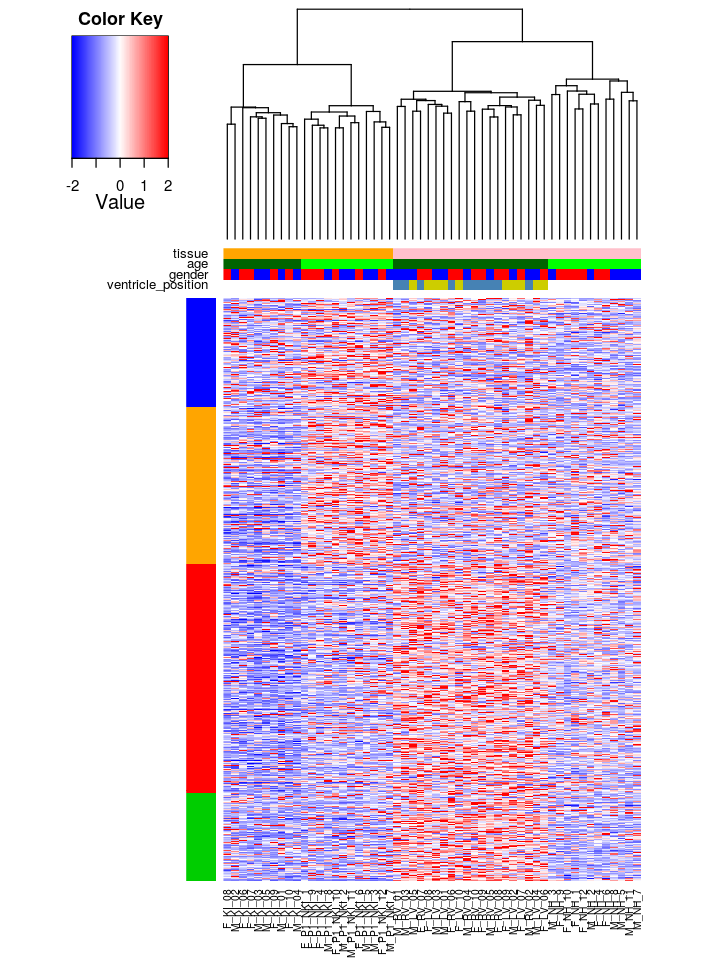

In [10]:
differential_sites_ = read.table('../_data/m6A/parsed_peaks/differential_sites_log1.5-tissue_specific.csv', header=T, sep='\t')
if("X"%in%colnames(differential_sites_))
{
    rownames(differential_sites_) = differential_sites_$X
    differential_sites_ = differential_sites_[,-1]
}
if("url"%in%colnames(differential_sites_))
{
    differential_sites_ = differential_sites_[,c(1,2,3,4)]
    rownames(differential_sites_) = gsub("-", ":", rownames(differential_sites_))
}

diff_group_ = c()
diff_idx_ = c()
diff_peak_ = c()
comparison_color_code = c('blue', 'orange', 'red', 'green3')
differential_sites_ = differential_sites_[, c("NHK", "Kidney_Age", "AHK", "Heart_Age")]
for(j in 1:ncol(differential_sites_))
{
	comparison = colnames(differential_sites_)[j]
	this_peak = rownames(differential_sites_)[differential_sites_[,j]!=0]
	diff_group_ = c(diff_group_, rep( comparison_color_code[j], length(this_peak)))
	diff_peak_ = c(diff_peak_, this_peak)
	diff_idx_ = c(diff_idx_, match(this_peak, rownames(data)))

}

diff_df_ = data.frame(
	group=diff_group_,
	peaks=diff_peak_,
	idx=diff_idx_,
	stringsAsFactors=F)

y_ = as.matrix(data[diff_df_$idx,])
y_ = t(scale(t(y_)))

hc_ = hclust(as.dist(1-cor(y_, method="spearman")), method="complete")


clab_ = data.frame(
	ventricle_position = 'white',
	gender = 'white',
	age = sapply(colnames(y_), function(x) ifelse(length(grep('N',x)), 'green', 'darkgreen')),
	tissue = sapply(colnames(y_), function(x) ifelse(length(grep('KI',x)), 'orange', 'pink')),
	stringsAsFactors=F
)
clab_$gender[ grep('M', colnames(y_)) ] = 'blue'
clab_$gender[ grep('F', colnames(y_)) ] = 'red'
clab_$ventricle_position[ grep('RV', colnames(y_)) ] = 'steelblue'
clab_$ventricle_position[ grep('LV', colnames(y_)) ] = 'yellow3'


clab_ = as.matrix(clab_)
rlab_ = as.matrix(diff_group_, nrow=1)

options(repr.plot.width=6, repr.plot.height=8)
print(dim(y_))
heatmap.3(y_, Rowv = NULL, Colv = as.dendrogram(hc_), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab_, key = TRUE,
    RowSideColors = t(rlab_))

if(SAVE_FIG) {
pdf('_data/PeakIntensity_AllDifferential-tissueSpecificGeneExpr.pdf')
heatmap.3(y_, Rowv = NULL, Colv = as.dendrogram(hc_), dendrogram = "col", 
    col = palette, 
    labRow=F, breaks=breaks,
    ColSideColors = clab_, key = TRUE,
    RowSideColors = t(rlab_))
dev.off()
}

### Heatmap on Differential between groups & Topology, Motif

Updated on Nov. 23, 2018: when plotting the differential peaks, also call the external scripts to run the homer script and topology distribution.


#### Neonatal Kidney vs Neonatal Heart

In [11]:
## Utils functions

write_BED_peaks = function(peaks, fn)
{
    write.table( gsub("\\.[1234567890]+", "", gsub(":", "\t", peaks)), file=fn, quote=F, row.names=F, col.names=F)
}

subset_heatmap = function(y, clab, subset_idx, diff_group_idx, main='', fn=NULL)
{
    print(dim(y))
    y_sub = y[diff_group_idx, subset_idx]
    y_sub = t(scale(t(y_sub)))
    hc1 = hclust(as.dist(1-cor(y_sub, method="pearson")), method="average")
    hr1 = hclust(as.dist(1-cor(t(y_sub), method="spearman")), method="average")
    clab1 = clab[subset_idx,]
    heatmap.3(y_sub, Rowv = as.dendrogram(hr1), Colv = as.dendrogram(hc1), dendrogram = "col", 
          col = palette, 
          labRow=F, breaks=breaks,
          ColSideColors = clab1, key = TRUE,
          main=main)
    if(SAVE_FIG && !is.null(fn)) {
        pdf(fn)
        heatmap.3(y_sub, Rowv = as.dendrogram(hr1), Colv = as.dendrogram(hc1), dendrogram = "col", 
              col = palette, 
              labRow=F, breaks=breaks,
              ColSideColors = clab1, key = TRUE,
              main=main)
        dev.off()
    }
    return(y_sub)
}

[1] 3670   54
[1] 1362   54


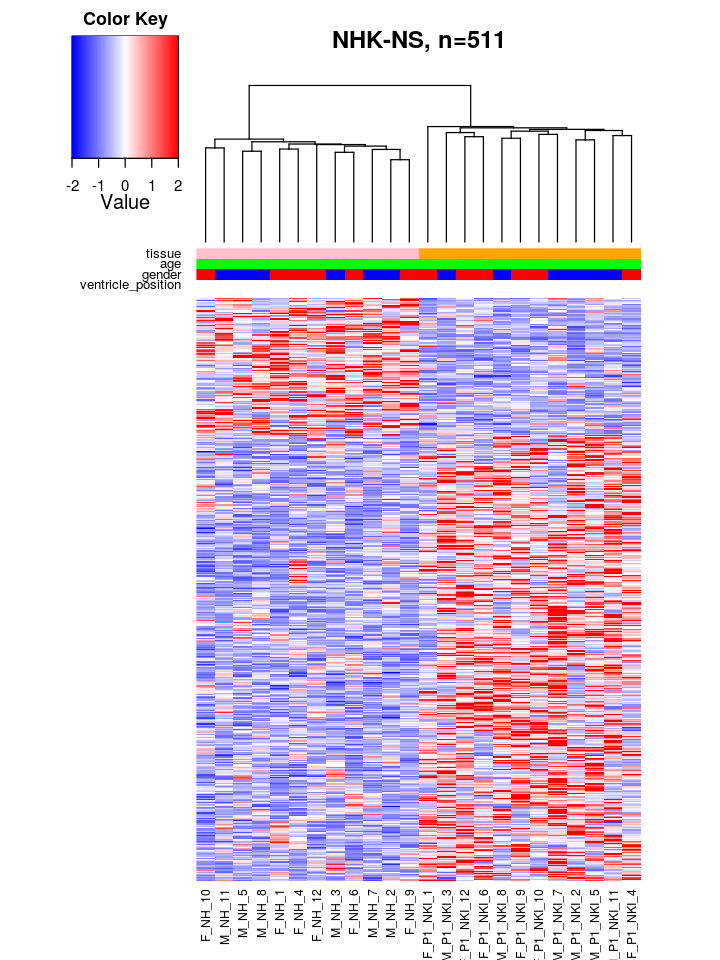

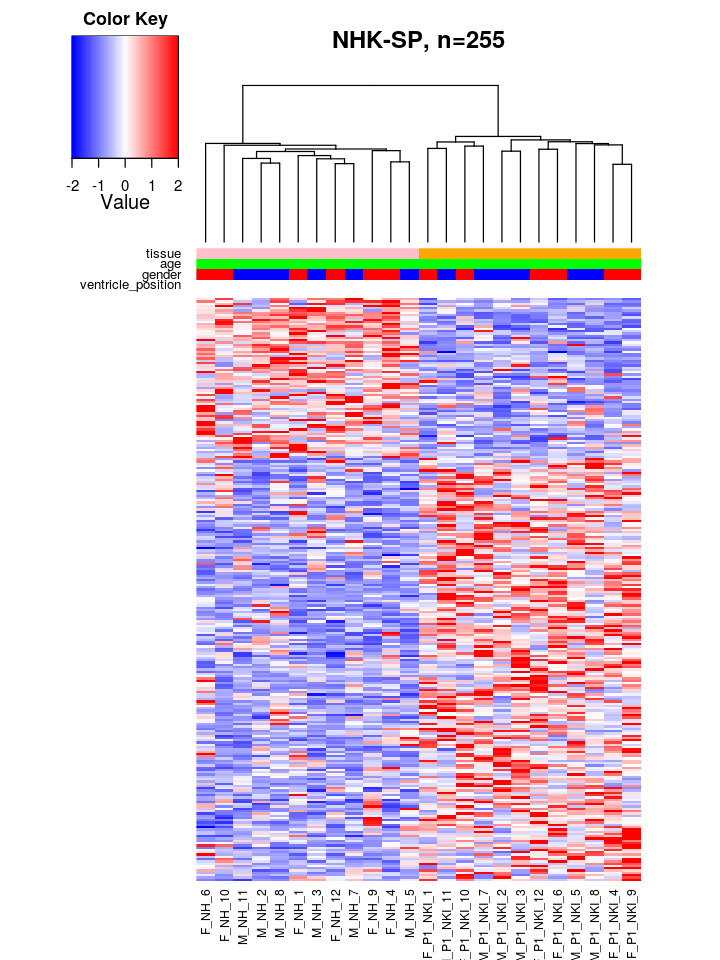

In [12]:
#################################
## neonatal kidney vs ventricle
idx1 = c(21:32, 33:44)
y1 = subset_heatmap(
    y, 
    clab, 
    idx1, 
    which(diff_group=='blue'), 
    paste0('NHK-NS, n=', sum(diff_group=='blue')), 
    '_data/PeakIntensity_Diff-NHK.pdf')

y1_ = subset_heatmap(
    y_, 
    clab_, 
    idx1, 
    which(diff_group_=='blue'), 
    paste0('NHK-SP, n=', sum(diff_group_=='blue')), 
    '_data/PeakIntensity_Diff-NHK-tissue_specific.pdf')

In [13]:
# Differential peaks on Non-differentially expressed genes
write_BED_peaks(rownames(y1), "_data/NHK.bed")
system( "bash run.sh _data/NHK.bed _data/DiffPeaks/NHK/" )

# Differential peaks on differentially expressed genes
write_BED_peaks(rownames(y1_), "_data/NHK_SP.bed")
system( "bash run.sh _data/NHK_SP.bed _data/DiffPeaks/NHK_SP/" )

#### Neonatal Kideny vs Adult Kidey

[1] 3670   54
[1] 1362   54


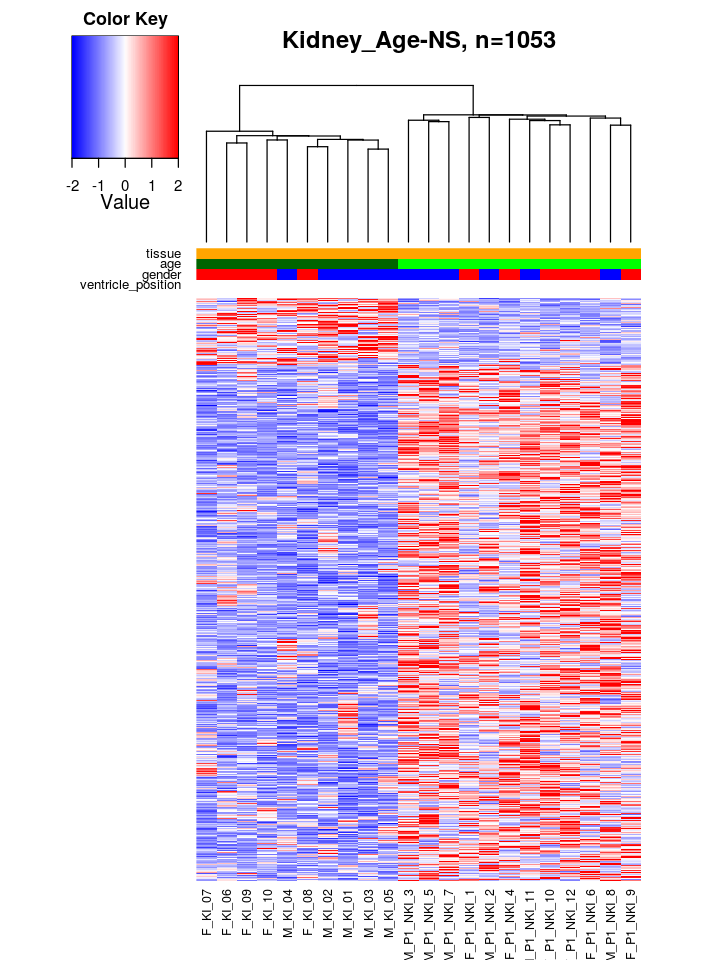

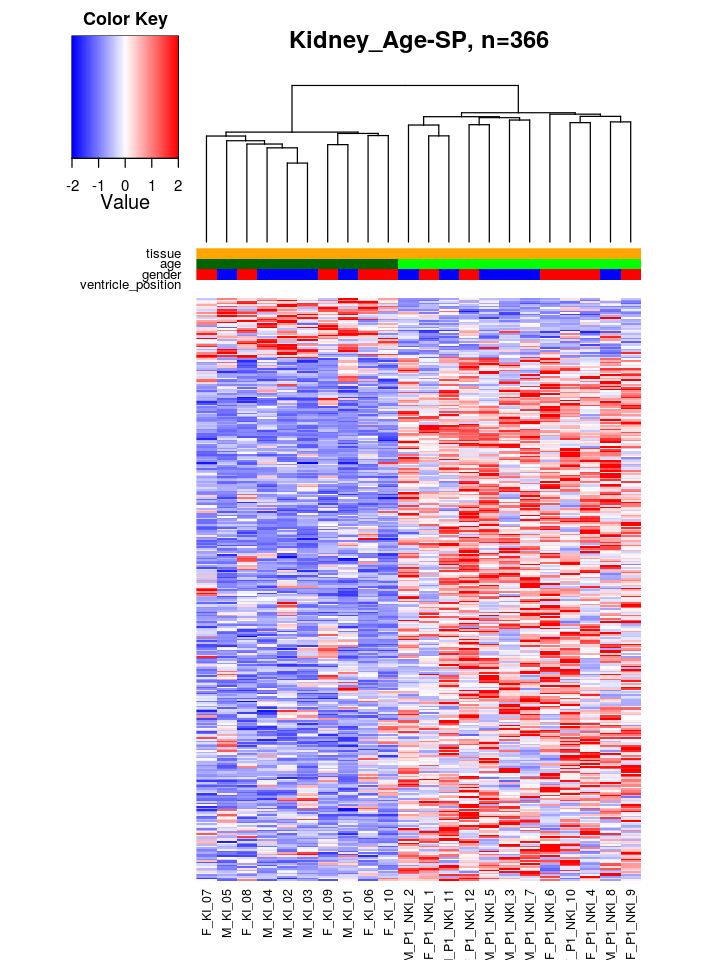

In [14]:
#################################
## neonatal kidney vs adult kidney

idx2 = c(1:5,16:20, 33:44)
y2 = subset_heatmap(
    y, 
    clab, 
    idx2, 
    which(diff_group=='orange'), 
    paste0('Kidney_Age-NS, n=', sum(diff_group=='orange')), 
    '_data/PeakIntensity_Diff-K_age.pdf')

y2_ = subset_heatmap(
    y_, 
    clab_, 
    idx2, 
    which(diff_group_=='orange'), 
    paste0('Kidney_Age-SP, n=', sum(diff_group_=='orange')), 
    '_data/PeakIntensity_Diff-K_age.pdf-tissue_specific.pdf')

In [15]:
write_BED_peaks(rownames(y2), "_data/Kidney_Age.bed")
system( "bash run.sh _data/Kidney_Age.bed _data/DiffPeaks/Kidney_Age/" )

write_BED_peaks(rownames(y2_), "_data/Kidney_Age_SP.bed")
system( "bash run.sh _data/Kidney_Age_SP.bed _data/DiffPeaks/Kidney_Age_SP/" )

#### Adult Kidney vs Adult Heart

[1] 3670   54
[1] 1362   54


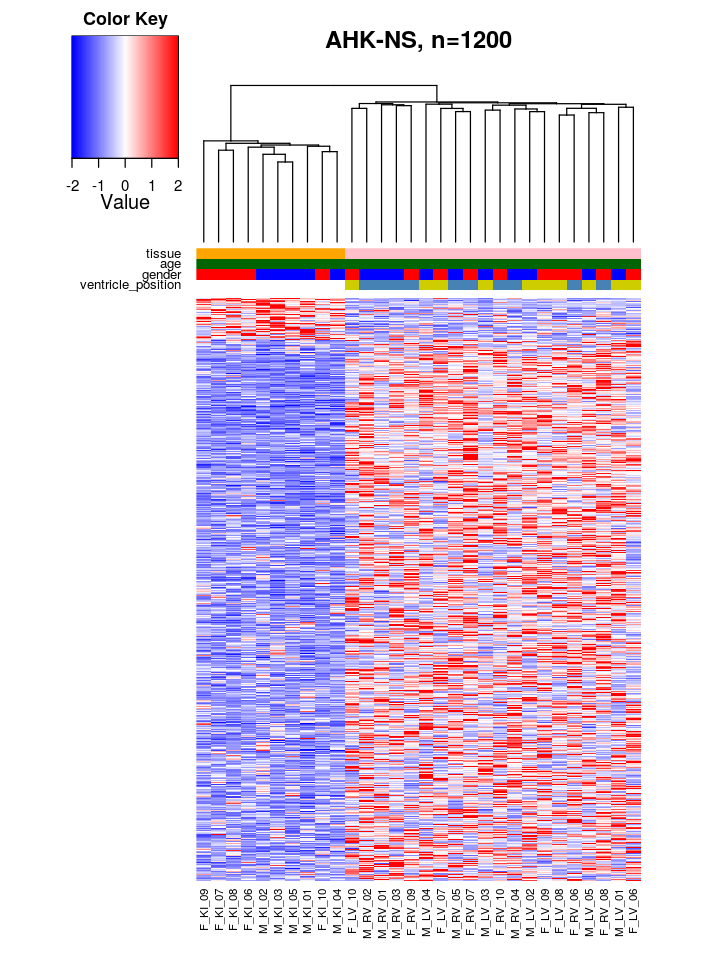

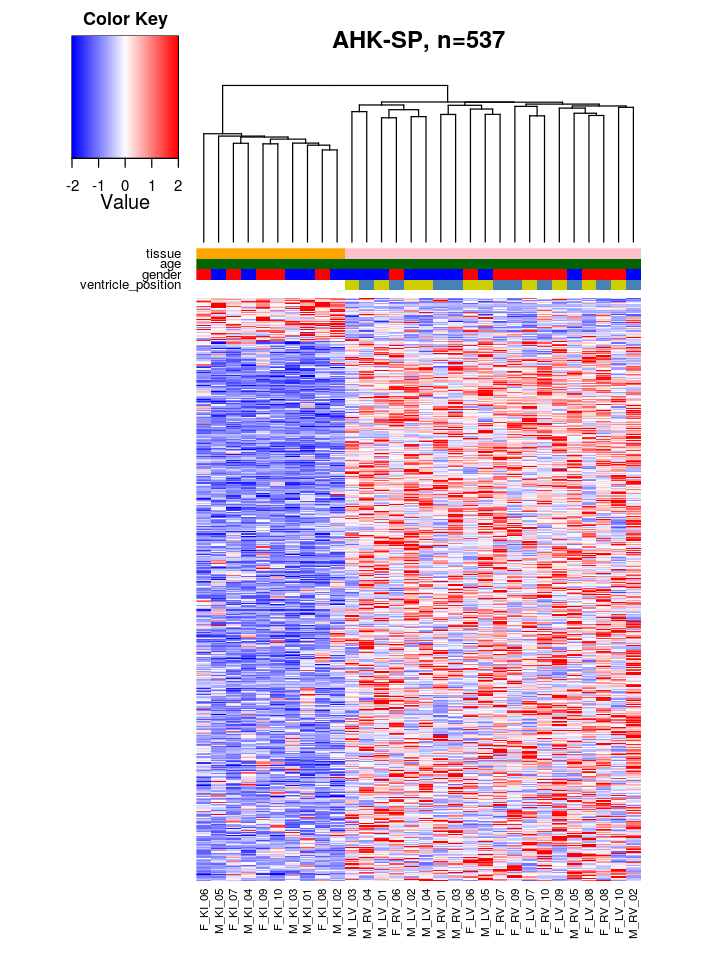

In [16]:
#################################
## adult kidney vs adult heart

idx3 = c(1:5,16:20, 6:15, 45:54)
y3 = subset_heatmap(
    y, 
    clab, 
    idx3, 
    which(diff_group=='red'), 
    paste0('AHK-NS, n=', sum(diff_group=='red')), 
    '_data/PeakIntensity_Diff-AHK.pdf')

y3_ = subset_heatmap(
    y_, 
    clab_, 
    idx3, 
    which(diff_group_=='red'), 
    paste0('AHK-SP, n=', sum(diff_group_=='red')), 
    '_data/PeakIntensity_Diff-AHK-tissue_specific.pdf')

In [17]:
write_BED_peaks(rownames(y3), "_data/AHK.bed")
system( "bash run.sh _data/AHK.bed _data/DiffPeaks/AHK/" )

write_BED_peaks(rownames(y3_), "_data/AHK_SP.bed")
system( "bash run.sh _data/AHK_SP.bed _data/DiffPeaks/AHK_SP/" )

#### Neonatal Heart vs Adult Heart

[1] 3670   54
[1] 1362   54


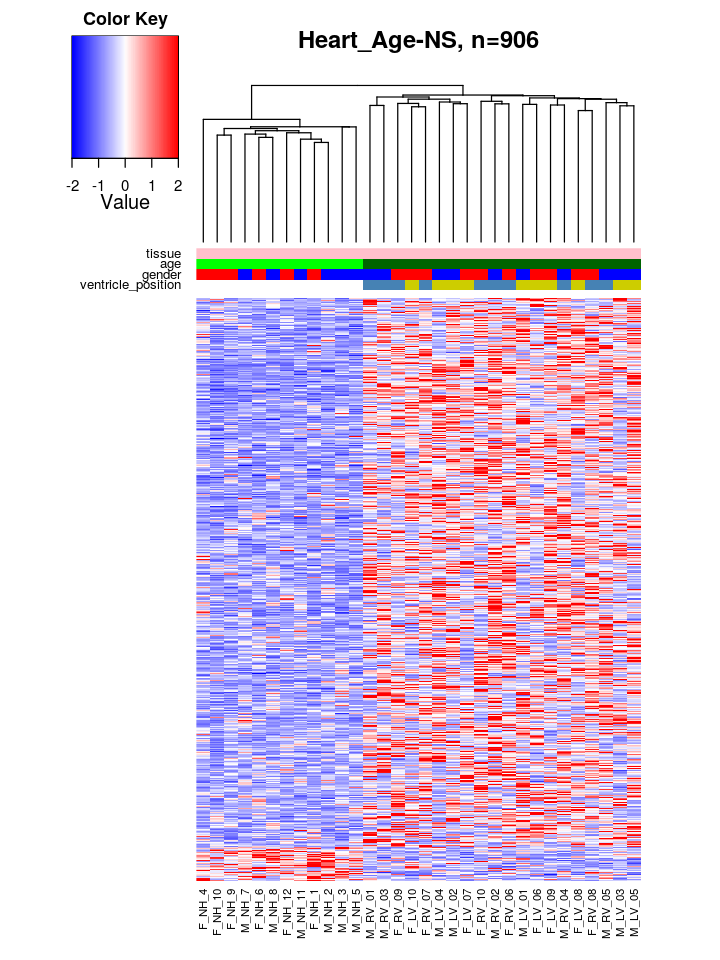

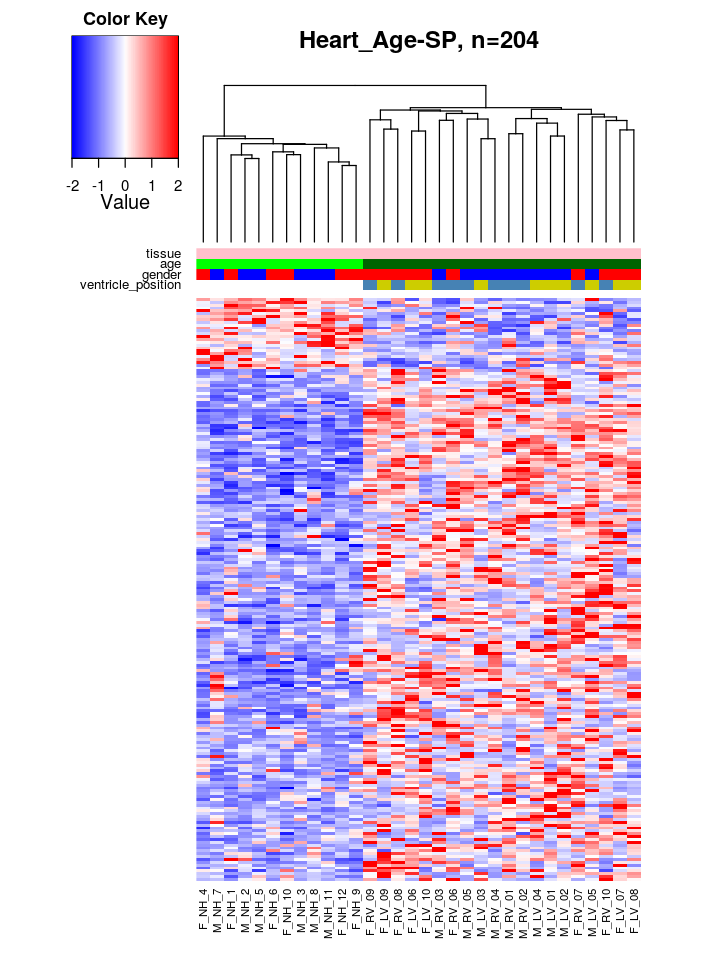

In [18]:
#################################
## neonatal heart vs adult heart

idx4 = c(21:32,6:15, 45:54)
y4 = subset_heatmap(
    y, 
    clab, 
    idx4, 
    which(diff_group=='green3'), 
    paste0('Heart_Age-NS, n=', sum(diff_group=='green3')), 
    '_data/PeakIntensity_Diff-Heart_Age.pdf')

y4_ = subset_heatmap(
    y_, 
    clab_, 
    idx4, 
    which(diff_group_=='green3'), 
    paste0('Heart_Age-SP, n=', sum(diff_group_=='green3')), 
    '_data/PeakIntensity_Diff-Heart_Age-tissue_specific.pdf')

In [19]:
write_BED_peaks(rownames(y4), "_data/Heart_Age.bed")
system( "bash run.sh _data/Heart_Age.bed _data/DiffPeaks/Heart_Age/" )

write_BED_peaks(rownames(y4_), "_data/Heart_Age_SP.bed")
system( "bash run.sh _data/Heart_Age_SP.bed _data/DiffPeaks/Heart_Age_SP/" )